In [6]:
from sklearn.linear_model import SGDClassifier  # Replaces KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import os
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score
from copy import deepcopy
from math import sqrt
from sklearn.utils import resample
from sklearn.metrics import make_scorer, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

In [2]:
derivation_cohort = pd.read_csv("Derivation_dataset.csv")
external_validation_cohort = pd.read_csv("External_validation_dataset.csv")

y = derivation_cohort['Outcome_Occlusion_MI']
X = derivation_cohort.drop('Outcome_Occlusion_MI', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 99)

for el in X_train.columns:
    X_train[el].fillna(X_train[el].mode()[0], inplace=True)
    X_val[el].fillna(X_train[el].mode()[0], inplace=True)

y_train = np.ravel(np.array(y_train.values))
y_val = np.ravel(np.array(y_val.values))

columns = X_train.columns

X_train = np.array(X_train.values)
X_val = np.array(X_val.values)

scaler = preprocessing.StandardScaler().fit(X_train) # Compute mean and std of training set
X_train = scaler.transform(X_train, copy=True)
X_val = scaler.transform(X_val, copy=True)

C:\Users\arthu\AppData\Local\Temp\ipykernel_77720\1077325655.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[el].fillna(X_train[el].mode()[0], inplace=True)
C:\Users\arthu\AppData\Local\Temp\ipykernel_77720\1077325655.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


In [3]:
def plot_ROC_curve(fpr, tpr, roc_auc, title):
    plt.figure(figsize=[5, 5])
    plt.title(title)
    plt.plot(fpr, tpr, color='b',
                 label=r'SGD_log_reg (AUC = %0.3f)' % (roc_auc),
                 lw=2, alpha=.8)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=.5)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate = 1 - Specificity')
    plt.ylabel('True Positive Rate = Sensitivity')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
def results(pred_probas):
    OMI_score = np.round(pred_probas[:, 1]*100, decimals=2)
    y_pred = np.where(OMI_score<5, 'Low risk', 'Intermediate risk')
    y_pred = np.where(OMI_score>=20, 'High risk', y_pred)
    
    results = {
        'Low risk': [np.count_nonzero(y_pred == 'Low risk')],
        'Intermediate risk': [np.count_nonzero(y_pred == 'Intermediate risk')],
        'High risk': [np.count_nonzero(y_pred == 'High risk')]
    }
    return(pd.DataFrame(data=results, index=['Count (N)']))

In [5]:
def bootstrap_metric_ci(y_true, y_pred, metric_fn, n_bootstrap=1000, alpha=0.05):
    """
    Compute 95% confidence interval using bootstrapping for any metric.
    
    Parameters:
    - y_true: Ground truth labels (0 or 1).
    - y_pred: Predicted values (either probabilities or binary predictions).
    - metric_fn: Metric function (roc_auc_score, recall_score, f1_score).
    - n_bootstrap: Number of bootstrap resamples.
    - alpha: Significance level (default 0.05 for 95% CI).

    Returns:
    - Lower and upper bound of the confidence interval.
    """
    scores = []
    
    for _ in range(n_bootstrap):
        # Resample dataset with replacement
        indices = resample(range(len(y_true)), replace=True, n_samples=len(y_true))
        y_true_bootstrap = np.array(y_true)[indices]
        y_pred_bootstrap = np.array(y_pred)[indices]

        # Special case for AUROC: Use roc_curve and auc()
        if metric_fn == "auroc":
            fpr, tpr, _ = roc_curve(y_true_bootstrap, y_pred_bootstrap)
            score = auc(fpr, tpr)
        else:
            score = metric_fn(y_true_bootstrap, y_pred_bootstrap)

        scores.append(score)
    
    # Compute confidence interval
    lower_bound = np.percentile(scores, 100 * (alpha / 2))
    upper_bound = np.percentile(scores, 100 * (1 - alpha / 2))
    
    return lower_bound, upper_bound

Hyperparameter Tuning with 10-Fold Cross-Validation
Searching for optimal hyperparameters across 144 combinations...


  3%|█████▊                                                                                                                                                                                                           | 4/144 [00:00<00:12, 10.91it/s]

Parameters: alpha=0.0001, penalty=l2, learning_rate=optimal, eta0=N/A, CV AUROC=0.7703 ± 0.0518
Parameters: alpha=0.0001, penalty=l2, learning_rate=invscaling, eta0=0.01, CV AUROC=0.8007 ± 0.0599


  6%|███████████▌                                                                                                                                                                                                     | 8/144 [00:00<00:09, 14.51it/s]

Parameters: alpha=0.0001, penalty=l2, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8317 ± 0.0488
Parameters: alpha=0.0001, penalty=l2, learning_rate=invscaling, eta0=1, CV AUROC=0.8265 ± 0.0383
Parameters: alpha=0.0001, penalty=l2, learning_rate=constant, eta0=0.01, CV AUROC=0.8223 ± 0.0372
Parameters: alpha=0.0001, penalty=l2, learning_rate=constant, eta0=0.1, CV AUROC=0.7464 ± 0.0678


  7%|██████████████▍                                                                                                                                                                                                 | 10/144 [00:00<00:10, 12.75it/s]

Parameters: alpha=0.0001, penalty=l2, learning_rate=constant, eta0=1, CV AUROC=0.6774 ± 0.1208
Parameters: alpha=0.0001, penalty=l2, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8329 ± 0.0368
Parameters: alpha=0.0001, penalty=l2, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8256 ± 0.0478


  8%|█████████████████▎                                                                                                                                                                                              | 12/144 [00:01<00:18,  7.11it/s]

Parameters: alpha=0.0001, penalty=l2, learning_rate=adaptive, eta0=1, CV AUROC=0.8239 ± 0.0461


 10%|████████████████████▏                                                                                                                                                                                           | 14/144 [00:02<00:36,  3.61it/s]

Parameters: alpha=0.0001, penalty=l1, learning_rate=optimal, eta0=N/A, CV AUROC=0.8060 ± 0.0587


 12%|████████████████████████▌                                                                                                                                                                                       | 17/144 [00:02<00:26,  4.73it/s]

Parameters: alpha=0.0001, penalty=l1, learning_rate=invscaling, eta0=0.01, CV AUROC=0.8003 ± 0.0603
Parameters: alpha=0.0001, penalty=l1, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8312 ± 0.0491


 13%|███████████████████████████▍                                                                                                                                                                                    | 19/144 [00:03<00:21,  5.88it/s]

Parameters: alpha=0.0001, penalty=l1, learning_rate=invscaling, eta0=1, CV AUROC=0.8266 ± 0.0393
Parameters: alpha=0.0001, penalty=l1, learning_rate=constant, eta0=0.01, CV AUROC=0.8245 ± 0.0374


 14%|████████████████████████████▉                                                                                                                                                                                   | 20/144 [00:03<00:21,  5.76it/s]

Parameters: alpha=0.0001, penalty=l1, learning_rate=constant, eta0=0.1, CV AUROC=0.7489 ± 0.0487


 15%|██████████████████████████████▎                                                                                                                                                                                 | 21/144 [00:03<00:23,  5.25it/s]

Parameters: alpha=0.0001, penalty=l1, learning_rate=constant, eta0=1, CV AUROC=0.7586 ± 0.0717


 15%|███████████████████████████████▊                                                                                                                                                                                | 22/144 [00:03<00:25,  4.71it/s]

Parameters: alpha=0.0001, penalty=l1, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8340 ± 0.0380


 16%|█████████████████████████████████▏                                                                                                                                                                              | 23/144 [00:04<00:35,  3.41it/s]

Parameters: alpha=0.0001, penalty=l1, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8252 ± 0.0495


 17%|██████████████████████████████████▋                                                                                                                                                                             | 24/144 [00:05<00:57,  2.09it/s]

Parameters: alpha=0.0001, penalty=l1, learning_rate=adaptive, eta0=1, CV AUROC=0.8235 ± 0.0516


 17%|████████████████████████████████████                                                                                                                                                                            | 25/144 [00:05<00:54,  2.19it/s]

Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=optimal, eta0=N/A, CV AUROC=0.7381 ± 0.0428


 20%|█████████████████████████████████████████▉                                                                                                                                                                      | 29/144 [00:06<00:25,  4.47it/s]

Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=invscaling, eta0=0.01, CV AUROC=0.8006 ± 0.0600
Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8316 ± 0.0487
Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=invscaling, eta0=1, CV AUROC=0.8272 ± 0.0386


 22%|██████████████████████████████████████████████▏                                                                                                                                                                 | 32/144 [00:06<00:17,  6.52it/s]

Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=constant, eta0=0.01, CV AUROC=0.8231 ± 0.0370
Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=constant, eta0=0.1, CV AUROC=0.7559 ± 0.0670
Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=constant, eta0=1, CV AUROC=0.7185 ± 0.1112


 24%|█████████████████████████████████████████████████                                                                                                                                                               | 34/144 [00:06<00:17,  6.24it/s]

Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8331 ± 0.0370


 24%|██████████████████████████████████████████████████▌                                                                                                                                                             | 35/144 [00:07<00:22,  4.81it/s]

Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8256 ± 0.0489


 26%|█████████████████████████████████████████████████████▍                                                                                                                                                          | 37/144 [00:07<00:29,  3.64it/s]

Parameters: alpha=0.0001, penalty=elasticnet, learning_rate=adaptive, eta0=1, CV AUROC=0.8237 ± 0.0471
Parameters: alpha=0.001, penalty=l2, learning_rate=optimal, eta0=N/A, CV AUROC=0.8228 ± 0.0438


 29%|████████████████████████████████████████████████████████████▋                                                                                                                                                   | 42/144 [00:08<00:13,  7.59it/s]

Parameters: alpha=0.001, penalty=l2, learning_rate=invscaling, eta0=0.01, CV AUROC=0.8007 ± 0.0599
Parameters: alpha=0.001, penalty=l2, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8314 ± 0.0488
Parameters: alpha=0.001, penalty=l2, learning_rate=invscaling, eta0=1, CV AUROC=0.8281 ± 0.0357
Parameters: alpha=0.001, penalty=l2, learning_rate=constant, eta0=0.01, CV AUROC=0.8235 ± 0.0385


 32%|██████████████████████████████████████████████████████████████████▍                                                                                                                                             | 46/144 [00:08<00:10,  9.65it/s]

Parameters: alpha=0.001, penalty=l2, learning_rate=constant, eta0=0.1, CV AUROC=0.7118 ± 0.1048
Parameters: alpha=0.001, penalty=l2, learning_rate=constant, eta0=1, CV AUROC=0.6532 ± 0.0585
Parameters: alpha=0.001, penalty=l2, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8355 ± 0.0369
Parameters: alpha=0.001, penalty=l2, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8328 ± 0.0399


 33%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                          | 48/144 [00:08<00:13,  7.06it/s]

Parameters: alpha=0.001, penalty=l2, learning_rate=adaptive, eta0=1, CV AUROC=0.8325 ± 0.0396


 34%|██████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 49/144 [00:10<00:43,  2.17it/s]

Parameters: alpha=0.001, penalty=l1, learning_rate=optimal, eta0=N/A, CV AUROC=0.7885 ± 0.0602


 37%|████████████████████████████████████████████████████████████████████████████▌                                                                                                                                   | 53/144 [00:11<00:25,  3.58it/s]

Parameters: alpha=0.001, penalty=l1, learning_rate=invscaling, eta0=0.01, CV AUROC=0.7952 ± 0.0624
Parameters: alpha=0.001, penalty=l1, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8261 ± 0.0549


 38%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                | 55/144 [00:11<00:19,  4.50it/s]

Parameters: alpha=0.001, penalty=l1, learning_rate=invscaling, eta0=1, CV AUROC=0.8338 ± 0.0392
Parameters: alpha=0.001, penalty=l1, learning_rate=constant, eta0=0.01, CV AUROC=0.8281 ± 0.0384


 39%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                               | 56/144 [00:11<00:18,  4.74it/s]

Parameters: alpha=0.001, penalty=l1, learning_rate=constant, eta0=0.1, CV AUROC=0.7626 ± 0.0688


 40%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                             | 57/144 [00:12<00:20,  4.25it/s]

Parameters: alpha=0.001, penalty=l1, learning_rate=constant, eta0=1, CV AUROC=0.6978 ± 0.0747


 40%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 58/144 [00:12<00:22,  3.78it/s]

Parameters: alpha=0.001, penalty=l1, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8354 ± 0.0409


 41%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 59/144 [00:12<00:28,  3.03it/s]

Parameters: alpha=0.001, penalty=l1, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8371 ± 0.0449


 42%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                         | 60/144 [00:13<00:39,  2.11it/s]

Parameters: alpha=0.001, penalty=l1, learning_rate=adaptive, eta0=1, CV AUROC=0.8337 ± 0.0447


 42%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 61/144 [00:14<00:37,  2.20it/s]

Parameters: alpha=0.001, penalty=elasticnet, learning_rate=optimal, eta0=N/A, CV AUROC=0.8214 ± 0.0426


 45%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                  | 65/144 [00:14<00:17,  4.44it/s]

Parameters: alpha=0.001, penalty=elasticnet, learning_rate=invscaling, eta0=0.01, CV AUROC=0.8002 ± 0.0604
Parameters: alpha=0.001, penalty=elasticnet, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8308 ± 0.0496


 47%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                               | 67/144 [00:14<00:13,  5.52it/s]

Parameters: alpha=0.001, penalty=elasticnet, learning_rate=invscaling, eta0=1, CV AUROC=0.8300 ± 0.0363
Parameters: alpha=0.001, penalty=elasticnet, learning_rate=constant, eta0=0.01, CV AUROC=0.8205 ± 0.0586


 47%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                             | 68/144 [00:14<00:14,  5.22it/s]

Parameters: alpha=0.001, penalty=elasticnet, learning_rate=constant, eta0=0.1, CV AUROC=0.7550 ± 0.0763


 48%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                            | 69/144 [00:15<00:17,  4.35it/s]

Parameters: alpha=0.001, penalty=elasticnet, learning_rate=constant, eta0=1, CV AUROC=0.6363 ± 0.1032


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 70/144 [00:15<00:18,  4.10it/s]

Parameters: alpha=0.001, penalty=elasticnet, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8359 ± 0.0379


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 71/144 [00:16<00:23,  3.09it/s]

Parameters: alpha=0.001, penalty=elasticnet, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8347 ± 0.0399


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 72/144 [00:17<00:35,  2.03it/s]

Parameters: alpha=0.001, penalty=elasticnet, learning_rate=adaptive, eta0=1, CV AUROC=0.8316 ± 0.0396


 51%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                      | 73/144 [00:17<00:29,  2.43it/s]

Parameters: alpha=0.01, penalty=l2, learning_rate=optimal, eta0=N/A, CV AUROC=0.8253 ± 0.0411
Parameters: alpha=0.01, penalty=l2, learning_rate=invscaling, eta0=0.01, CV AUROC=0.7998 ± 0.0604


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                               | 78/144 [00:17<00:10,  6.05it/s]

Parameters: alpha=0.01, penalty=l2, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8273 ± 0.0516
Parameters: alpha=0.01, penalty=l2, learning_rate=invscaling, eta0=1, CV AUROC=0.8200 ± 0.0506
Parameters: alpha=0.01, penalty=l2, learning_rate=constant, eta0=0.01, CV AUROC=0.8059 ± 0.0561
Parameters: alpha=0.01, penalty=l2, learning_rate=constant, eta0=0.1, CV AUROC=0.6734 ± 0.0836


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                           | 81/144 [00:17<00:07,  8.65it/s]

Parameters: alpha=0.01, penalty=l2, learning_rate=constant, eta0=1, CV AUROC=0.5484 ± 0.0900
Parameters: alpha=0.01, penalty=l2, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8346 ± 0.0434


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                        | 83/144 [00:18<00:08,  7.58it/s]

Parameters: alpha=0.01, penalty=l2, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8349 ± 0.0428
Parameters: alpha=0.01, penalty=l2, learning_rate=adaptive, eta0=1, CV AUROC=0.8339 ± 0.0426


 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 85/144 [00:19<00:17,  3.33it/s]

Parameters: alpha=0.01, penalty=l1, learning_rate=optimal, eta0=N/A, CV AUROC=0.7882 ± 0.0628


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 89/144 [00:20<00:13,  4.16it/s]

Parameters: alpha=0.01, penalty=l1, learning_rate=invscaling, eta0=0.01, CV AUROC=0.7636 ± 0.0715
Parameters: alpha=0.01, penalty=l1, learning_rate=invscaling, eta0=0.1, CV AUROC=0.7887 ± 0.0668


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 91/144 [00:20<00:11,  4.78it/s]

Parameters: alpha=0.01, penalty=l1, learning_rate=invscaling, eta0=1, CV AUROC=0.7941 ± 0.0615
Parameters: alpha=0.01, penalty=l1, learning_rate=constant, eta0=0.01, CV AUROC=0.7859 ± 0.0594


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 93/144 [00:20<00:09,  5.28it/s]

Parameters: alpha=0.01, penalty=l1, learning_rate=constant, eta0=0.1, CV AUROC=0.7294 ± 0.0598
Parameters: alpha=0.01, penalty=l1, learning_rate=constant, eta0=1, CV AUROC=0.6768 ± 0.0795


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 94/144 [00:21<00:13,  3.73it/s]

Parameters: alpha=0.01, penalty=l1, learning_rate=adaptive, eta0=0.01, CV AUROC=0.7918 ± 0.0595


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 95/144 [00:21<00:17,  2.77it/s]

Parameters: alpha=0.01, penalty=l1, learning_rate=adaptive, eta0=0.1, CV AUROC=0.7917 ± 0.0591


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 96/144 [00:22<00:23,  2.06it/s]

Parameters: alpha=0.01, penalty=l1, learning_rate=adaptive, eta0=1, CV AUROC=0.7873 ± 0.0616


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 97/144 [00:23<00:23,  2.01it/s]

Parameters: alpha=0.01, penalty=elasticnet, learning_rate=optimal, eta0=N/A, CV AUROC=0.8164 ± 0.0464


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 101/144 [00:23<00:11,  3.84it/s]

Parameters: alpha=0.01, penalty=elasticnet, learning_rate=invscaling, eta0=0.01, CV AUROC=0.7922 ± 0.0632
Parameters: alpha=0.01, penalty=elasticnet, learning_rate=invscaling, eta0=0.1, CV AUROC=0.8167 ± 0.0591


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 103/144 [00:23<00:08,  5.09it/s]

Parameters: alpha=0.01, penalty=elasticnet, learning_rate=invscaling, eta0=1, CV AUROC=0.8113 ± 0.0552
Parameters: alpha=0.01, penalty=elasticnet, learning_rate=constant, eta0=0.01, CV AUROC=0.8069 ± 0.0587


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 104/144 [00:24<00:07,  5.22it/s]

Parameters: alpha=0.01, penalty=elasticnet, learning_rate=constant, eta0=0.1, CV AUROC=0.7218 ± 0.0709


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 105/144 [00:24<00:08,  4.80it/s]

Parameters: alpha=0.01, penalty=elasticnet, learning_rate=constant, eta0=1, CV AUROC=0.6608 ± 0.0552


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 106/144 [00:24<00:09,  4.18it/s]

Parameters: alpha=0.01, penalty=elasticnet, learning_rate=adaptive, eta0=0.01, CV AUROC=0.8264 ± 0.0518


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 107/144 [00:25<00:11,  3.12it/s]

Parameters: alpha=0.01, penalty=elasticnet, learning_rate=adaptive, eta0=0.1, CV AUROC=0.8251 ± 0.0540


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 108/144 [00:26<00:16,  2.23it/s]

Parameters: alpha=0.01, penalty=elasticnet, learning_rate=adaptive, eta0=1, CV AUROC=0.8175 ± 0.0550
Parameters: alpha=0.1, penalty=l2, learning_rate=optimal, eta0=N/A, CV AUROC=0.7826 ± 0.0651


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 114/144 [00:26<00:04,  6.16it/s]

Parameters: alpha=0.1, penalty=l2, learning_rate=invscaling, eta0=0.01, CV AUROC=0.7910 ± 0.0628
Parameters: alpha=0.1, penalty=l2, learning_rate=invscaling, eta0=0.1, CV AUROC=0.7950 ± 0.0629
Parameters: alpha=0.1, penalty=l2, learning_rate=invscaling, eta0=1, CV AUROC=0.7782 ± 0.0704
Parameters: alpha=0.1, penalty=l2, learning_rate=constant, eta0=0.01, CV AUROC=0.7464 ± 0.0683
Parameters: alpha=0.1, penalty=l2, learning_rate=constant, eta0=0.1, CV AUROC=0.5720 ± 0.1223


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 117/144 [00:26<00:03,  8.59it/s]

Parameters: alpha=0.1, penalty=l2, learning_rate=constant, eta0=1, CV AUROC=0.4645 ± 0.1089
Parameters: alpha=0.1, penalty=l2, learning_rate=adaptive, eta0=0.01, CV AUROC=0.7930 ± 0.0638


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 119/144 [00:26<00:03,  7.71it/s]

Parameters: alpha=0.1, penalty=l2, learning_rate=adaptive, eta0=0.1, CV AUROC=0.7939 ± 0.0628


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 121/144 [00:27<00:03,  6.47it/s]

Parameters: alpha=0.1, penalty=l2, learning_rate=adaptive, eta0=1, CV AUROC=0.7934 ± 0.0640
Parameters: alpha=0.1, penalty=l1, learning_rate=optimal, eta0=N/A, CV AUROC=0.5000 ± 0.0000


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 125/144 [00:28<00:03,  5.87it/s]

Parameters: alpha=0.1, penalty=l1, learning_rate=invscaling, eta0=0.01, CV AUROC=0.5000 ± 0.0000
Parameters: alpha=0.1, penalty=l1, learning_rate=invscaling, eta0=0.1, CV AUROC=0.5000 ± 0.0000


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 128/144 [00:28<00:02,  7.32it/s]

Parameters: alpha=0.1, penalty=l1, learning_rate=invscaling, eta0=1, CV AUROC=0.5000 ± 0.0000
Parameters: alpha=0.1, penalty=l1, learning_rate=constant, eta0=0.01, CV AUROC=0.5000 ± 0.0000
Parameters: alpha=0.1, penalty=l1, learning_rate=constant, eta0=0.1, CV AUROC=0.5000 ± 0.0000


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 129/144 [00:28<00:02,  7.23it/s]

Parameters: alpha=0.1, penalty=l1, learning_rate=constant, eta0=1, CV AUROC=0.5000 ± 0.0000


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 130/144 [00:28<00:03,  4.37it/s]

Parameters: alpha=0.1, penalty=l1, learning_rate=adaptive, eta0=0.01, CV AUROC=0.5000 ± 0.0000


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 131/144 [00:29<00:04,  3.07it/s]

Parameters: alpha=0.1, penalty=l1, learning_rate=adaptive, eta0=0.1, CV AUROC=0.5000 ± 0.0000


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 132/144 [00:30<00:05,  2.30it/s]

Parameters: alpha=0.1, penalty=l1, learning_rate=adaptive, eta0=1, CV AUROC=0.5000 ± 0.0000
Parameters: alpha=0.1, penalty=elasticnet, learning_rate=optimal, eta0=N/A, CV AUROC=0.7233 ± 0.0757


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 137/144 [00:31<00:01,  3.89it/s]

Parameters: alpha=0.1, penalty=elasticnet, learning_rate=invscaling, eta0=0.01, CV AUROC=0.7328 ± 0.0797
Parameters: alpha=0.1, penalty=elasticnet, learning_rate=invscaling, eta0=0.1, CV AUROC=0.7352 ± 0.0792


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 139/144 [00:31<00:01,  4.86it/s]

Parameters: alpha=0.1, penalty=elasticnet, learning_rate=invscaling, eta0=1, CV AUROC=0.7245 ± 0.0936
Parameters: alpha=0.1, penalty=elasticnet, learning_rate=constant, eta0=0.01, CV AUROC=0.7415 ± 0.0729


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 141/144 [00:31<00:00,  5.58it/s]

Parameters: alpha=0.1, penalty=elasticnet, learning_rate=constant, eta0=0.1, CV AUROC=0.6476 ± 0.0849
Parameters: alpha=0.1, penalty=elasticnet, learning_rate=constant, eta0=1, CV AUROC=0.5838 ± 0.1019


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 142/144 [00:32<00:00,  3.79it/s]

Parameters: alpha=0.1, penalty=elasticnet, learning_rate=adaptive, eta0=0.01, CV AUROC=0.7361 ± 0.0769


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 143/144 [00:32<00:00,  2.69it/s]

Parameters: alpha=0.1, penalty=elasticnet, learning_rate=adaptive, eta0=0.1, CV AUROC=0.7350 ± 0.0769


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:33<00:00,  4.26it/s]

Parameters: alpha=0.1, penalty=elasticnet, learning_rate=adaptive, eta0=1, CV AUROC=0.7339 ± 0.0789

Top 5 parameter combinations:
    alpha     penalty learning_rate  eta0  mean_auroc  std_auroc
48  0.001          l1      adaptive   0.1    0.837147   0.044878
57  0.001  elasticnet      adaptive  0.01    0.835941   0.037854
37  0.001          l2      adaptive  0.01    0.835450   0.036910
47  0.001          l1      adaptive  0.01    0.835388   0.040919
68  0.010          l2      adaptive   0.1    0.834942   0.042808

Best Parameters: {'alpha': 0.001, 'penalty': 'l1', 'learning_rate': 'adaptive', 'eta0': 0.1}
Best Cross-Validation AUROC: 0.8371
Best model saved as 'best_sgd_model.pkl'


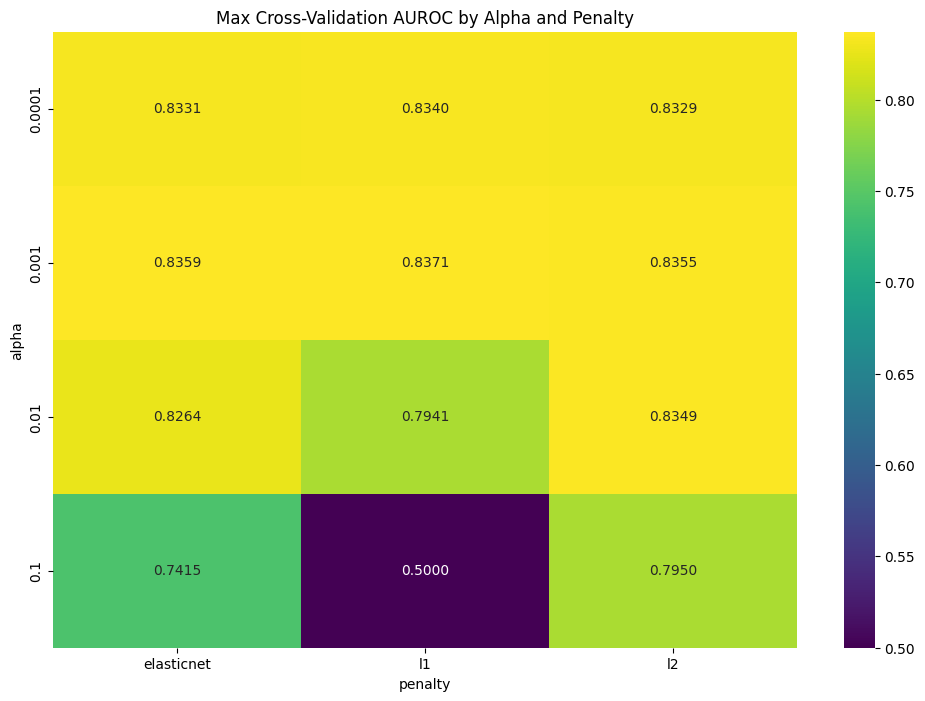

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
from tqdm import tqdm
import pandas as pd

print("Hyperparameter Tuning with 10-Fold Cross-Validation")
best_mean_auroc = 0
best_params = {}
best_model = None

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Parameter grid
alpha_values = [0.0001, 0.001, 0.01, 0.1]  # Regularization strength
penalty_values = ['l2', 'l1', 'elasticnet']  # Regularization type
learning_rate_values = ['optimal', 'invscaling', 'constant', 'adaptive']  # Learning rate schedule
eta0_values = [0.01, 0.1, 1]  # Initial learning rate, must be > 0

# Calculate total number of parameter combinations
total_combinations = len(alpha_values) * len(penalty_values) * len(learning_rate_values) * len(eta0_values)
print(f"Searching for optimal hyperparameters across {total_combinations} combinations...")

# Store results for later analysis
results_list = []

# Use tqdm for progress tracking
pbar = tqdm(total=total_combinations)

for alpha in alpha_values:
    for penalty in penalty_values:
        for learning_rate in learning_rate_values:
            for eta0 in eta0_values:
                # Skip combinations where eta0 is not needed
                if learning_rate == 'optimal' and eta0 != eta0_values[0]:
                    pbar.update(1)
                    continue
                
                # Ensure eta0 is used only when necessary
                params = {
                    'loss': 'log_loss', 'alpha': alpha, 'penalty': penalty,
                    'max_iter': 1000, 'tol': 1e-3, 'learning_rate': learning_rate,
                    'random_state': 42
                }
                
                # eta0 is required for 'constant', 'invscaling', and 'adaptive' learning rates
                if learning_rate in ['constant', 'invscaling', 'adaptive']:
                    params['eta0'] = eta0
                
                try:
                    # List to store AUROC scores for each fold
                    fold_aurocs = []
                    
                    # Perform cross-validation
                    for train_idx, val_idx in cv.split(X_train, y_train):
                        # Split data for this fold
                        X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
                        y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]
                        
                        # Create and train SGD Logistic Regression model with current parameters
                        current_sgd = SGDClassifier(**params)
                        current_sgd.fit(X_fold_train, y_fold_train)
                        
                        # Evaluate on validation fold using AUROC
                        val_probas = current_sgd.predict_proba(X_fold_val)[:, 1]  # Get positive class probabilities
                        auroc_val = roc_auc_score(y_fold_val, val_probas)
                        fold_aurocs.append(auroc_val)
                    
                    # Calculate mean and standard deviation across folds
                    mean_auroc = np.mean(fold_aurocs)
                    std_auroc = np.std(fold_aurocs)
                    
                    eta0_text = eta0 if learning_rate in ['constant', 'invscaling', 'adaptive'] else 'N/A'
                    print(f"Parameters: alpha={alpha}, penalty={penalty}, learning_rate={learning_rate}, eta0={eta0_text}, CV AUROC={mean_auroc:.4f} ± {std_auroc:.4f}")
                    
                    # Store results
                    results_list.append({
                        'alpha': alpha,
                        'penalty': penalty,
                        'learning_rate': learning_rate,
                        'eta0': eta0_text,
                        'mean_auroc': mean_auroc,
                        'std_auroc': std_auroc
                    })
                    
                    # Track best model based on mean AUROC
                    if mean_auroc > best_mean_auroc:
                        best_mean_auroc = mean_auroc
                        best_params = {
                            'alpha': alpha,
                            'penalty': penalty,
                            'learning_rate': learning_rate,
                            'eta0': eta0_text if eta0_text != 'N/A' else None
                        }
                
                except Exception as e:
                    print(f"Error with parameters: alpha={alpha}, penalty={penalty}, learning_rate={learning_rate}, eta0={eta0 if learning_rate in ['constant', 'invscaling', 'adaptive'] else 'N/A'}")
                    print(f"Error message: {str(e)}")
                
                # Update progress bar
                pbar.update(1)

pbar.close()

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results_list)
print("\nTop 5 parameter combinations:")
print(results_df.sort_values('mean_auroc', ascending=False).head(5))

# Create final model with best parameters
final_params = {
    'loss': 'log_loss', 
    'alpha': best_params['alpha'], 
    'penalty': best_params['penalty'],
    'learning_rate': best_params['learning_rate'],
    'max_iter': 1000, 
    'tol': 1e-3,
    'random_state': 42
}

if best_params['eta0'] is not None:
    final_params['eta0'] = best_params['eta0']

print(f"\nBest Parameters: {best_params}")
print(f"Best Cross-Validation AUROC: {best_mean_auroc:.4f}")

# Train final model with best parameters on the full training set
best_model = SGDClassifier(**final_params)
best_model.fit(X_train, y_train)

# If you want to evaluate the best model on a test set (if available)
if 'X_test' in locals() and 'y_test' in locals():
    test_probas = best_model.predict_proba(X_test)[:, 1]
    test_auroc = roc_auc_score(y_test, test_probas)
    print(f"Test set AUROC for best model: {test_auroc:.4f}")

# Save the best model
import joblib
joblib.dump(best_model, 'best_sgd_model.pkl')
print("Best model saved as 'best_sgd_model.pkl'")

# Use the best model found
clf = best_model

# Optionally, plot heatmap of performances
import matplotlib.pyplot as plt
import seaborn as sns

# Create pivot table of mean AUROC scores grouped by alpha and penalty
plt.figure(figsize=(12, 8))
pivot = results_df.pivot_table(
    index='alpha', 
    columns='penalty',
    values='mean_auroc',
    aggfunc='max'  # Max AUROC across learning_rate and eta0 values
)
sns.heatmap(pivot, annot=True, cmap='viridis', fmt='.4f')
plt.title('Max Cross-Validation AUROC by Alpha and Penalty')
plt.savefig('sgd_performance_heatmap.png')

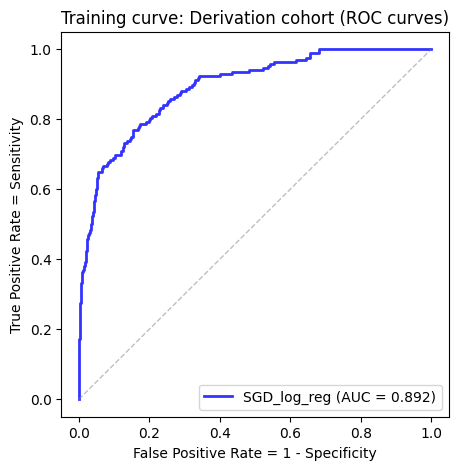

Training AUROC: 0.892 (95% CI: 0.867, 0.915)


In [8]:
# Predict on training data
pred_probas_train = clf.predict_proba(X_train)
risk_groups_train = results(pred_probas_train)

# Compute ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_train, pred_probas_train[:,1])
roc_auc = auc(fpr, tpr)
plot_ROC_curve(fpr, tpr, roc_auc, 'Training curve: Derivation cohort (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_train, auroc_ci_upper_train = bootstrap_metric_ci(y_train, pred_probas_train[:,1], "auroc")

print(f"Training AUROC: {roc_auc:.3f} (95% CI: {auroc_ci_lower_train:.3f}, {auroc_ci_upper_train:.3f})")


Val


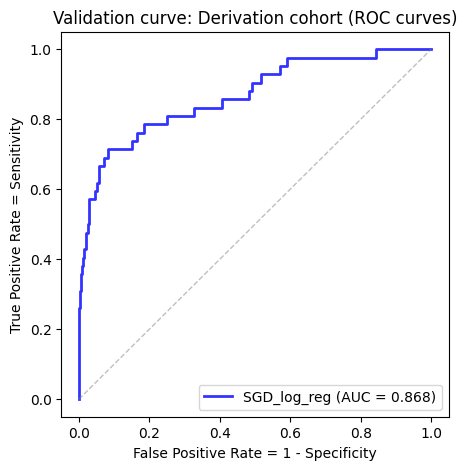

Val AUROC: 0.868 (95% CI: 0.793, 0.934)


In [9]:
# Evaluate on validation set
print("\nVal")
pred_probas_val = clf.predict_proba(X_val)
risk_groups_val = results(pred_probas_val)

# Compute ROC curve and area under the curve for validation set
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, pred_probas_val[:,1])
roc_auc_val = auc(fpr_val, tpr_val)
plot_ROC_curve(fpr_val, tpr_val, roc_auc_val, 'Validation curve: Derivation cohort (ROC curves)')

# Compute AUROC CI
auroc_ci_lower_val, auroc_ci_upper_val = bootstrap_metric_ci(y_val, pred_probas_val[:,1], "auroc")

print(f"Val AUROC: {roc_auc_val:.3f} (95% CI: {auroc_ci_lower_val:.3f}, {auroc_ci_upper_val:.3f})")